In [5]:
import os
import sys  
import pandas as pd
import PredictorOptimize
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.interpolate import Rbf
import numpy as np
import SHMI_PREDICTOR_SUPERVISED

In [6]:
train_data = pd.read_csv('covid19-global-forecasting-week-1/train.csv')
population = pd.read_csv('WorldPopulation/API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv')
p_density = pd.read_csv('WorldPopulation/API_EN.POP.DNST_DS2_en_csv_v2_887474.csv')
population_density = pd.merge(population[['Country Code','Country Name','2018']], p_density[['Country Code','2018']], on = 'Country Code')
population_density.columns = ['Country Code', 'Country Name', 'Population', 'Density']


In [4]:
population_density= population_density.set_value(249,'Country Name', 'US')
population_density= population_density.set_value(29,'Country Name', 'Brunei')
population_density= population_density.set_value(42,'Country Name', 'Congo (Brazzaville)')
population_density= population_density.set_value(41,'Country Name', 'Congo (Kinshasa)')
population_density= population_density.set_value(52,'Country Name', 'Czechia')
population_density= population_density.set_value(65,'Country Name', 'Egypt')
population_density= population_density.set_value(92,'Country Name', 'French Guiana')
population_density= population_density.set_value(124,'Country Name', 'Korea, South')
population_density= population_density.set_value(252,'Country Name', 'Venezuela')
population_density= population_density.set_value(84,'Country Name', 'The Gambia')
population_density= population_density.set_value(21,'Country Name', 'The Bahamas')
population_density= population_density.set_value(219,'Country Name', 'Slovakia')
population_density= population_density.set_value(251,'Country Name', 'Saint Vincent and the Grenadines')
population_density= population_density.set_value(131,'Country Name', 'Saint Lucia')
population_density= population_density.set_value(200,'Country Name', 'Russia')

In [5]:
train_data.nunique()

Id                16188
Province/State      128
Country/Region      163
Lat                 272
Long                276
Date                 57
ConfirmedCases      797
Fatalities          136
dtype: int64

In [6]:
df_china= train_data[train_data['Country/Region'] == 'China'][['Date','Province/State','ConfirmedCases','Fatalities']]
df_china.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_china.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_china.groupby(['Province/State','Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.loc['Hubei'].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x182e11efa58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182e14f4ef0>)

(<matplotlib.axes._subplots.AxesSubplot at 0x182e16dd438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182e188db70>)

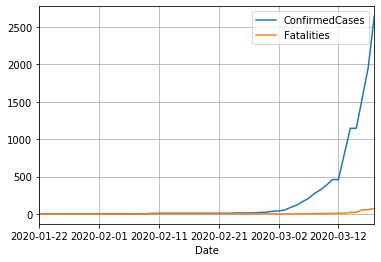

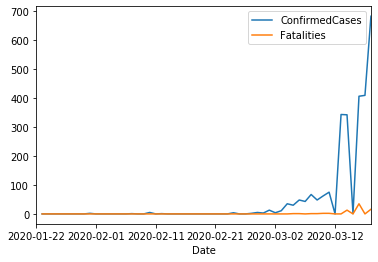

In [7]:
Country = 'United Kingdom'
df_c = train_data[train_data['Country/Region'] == Country][['Date','Province/State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x182e1908470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182e19b0c18>)

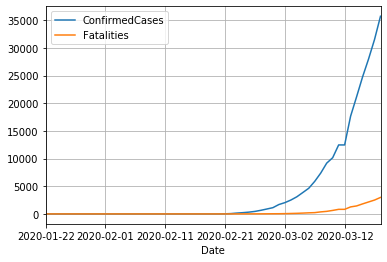

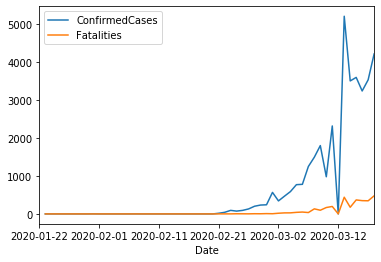

In [8]:
Country = 'Italy'
df_c = train_data[train_data['Country/Region'] == Country][['Date','Province/State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
df_acumed_daycases.plot(grid=True),df_diff_daycases.plot()

In [9]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)
def predict_n_steps_AR(data, n_steps, use_new_model = True,maxlag=3):
    data_history = data
    if n_steps < 5:
        for i in range(n_steps):
            model = AR(data_history)
            model_fit = model.fit(maxlag=maxlag, disp=True)
            yhat = model_fit.predict(len(data_history), len(data_history))
            data_history = np.concatenate((data_history, yhat))
    else:
        total = sum(data_history)
        if total < 1000:
            for i in range(min(14,n_steps)):
                model = AR(data_history)
                model_fit = model.fit(maxlag=1, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
            if sum(data_history) >= 15000:
                for i in range(14,min(20,n_steps)):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=3, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
                for i in range(20,n_steps):
                    t,d,s,p,b,r = ['add', True, None, None, False, True]
                    model = ExponentialSmoothing(data_history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
                    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
            else:
                for i in range(14,n_steps):
                    model = AR(data_history)
                    model_fit = model.fit(maxlag=1, disp=True)
                    yhat = model_fit.predict(len(data_history), len(data_history))
                    data_history = np.concatenate((data_history, yhat))
        else:
            for i in range(n_steps):
                model = AR(data_history)
                model_fit = model.fit(maxlag=maxlag, disp=True)
                yhat = model_fit.predict(len(data_history), len(data_history))
                data_history = np.concatenate((data_history, yhat))
    return data_history

f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


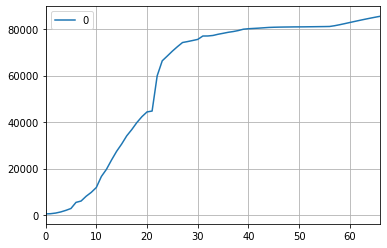

In [10]:
Country = 'China'
df_c = train_data[train_data['Country/Region'] == Country][['Date','Province/State','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
data = df_acumed_daycases['ConfirmedCases'].astype('float')
forecasted = pd.DataFrame(predict_n_steps_AR(data, 10, use_new_model = True))
forecasted.plot(grid=True)
#pd.DataFrame(predict_n_steps_AR(data, 10, use_new_model = True))

In [12]:
Country = 'United Kingdom'
df_c = train_data[train_data['Country/Region'] == Country][['Date','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
data = df_acumed_daycases['ConfirmedCases'].astype('float')
predict_n_steps_AR(data, 12, use_new_model = True)

f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
       2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
       3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 8.00000000e+00,
       8.00000000e+00, 9.00000000e+00, 9.00000000e+00, 9.00000000e+00,
       9.00000000e+00, 9.00000000e+00, 9.00000000e+00, 9.00000000e+00,
       9.00000000e+00, 9.00000000e+00, 9.00000000e+00, 9.00000000e+00,
       9.00000000e+00, 1.30000000e+01, 1.30000000e+01, 1.30000000e+01,
       1.50000000e+01, 2.00000000e+01, 2.30000000e+01, 3.60000000e+01,
       4.00000000e+01, 5.10000000e+01, 8.60000000e+01, 1.16000000e+02,
       1.64000000e+02, 2.07000000e+02, 2.74000000e+02, 3.22000000e+02,
       3.84000000e+02, 4.59000000e+02, 4.59000000e+02, 8.02000000e+02,
       1.14400000e+03, 1.14500000e+03, 1.55100000e+03, 1.96000000e+03,
      

In [11]:
Country = 'United Kingdom'
df_c = train_data[train_data['Country/Region'] == Country][['Date','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
data = df_acumed_daycases['ConfirmedCases'].astype('float')
print(data)
result = predict_n_steps_AR(data, 36, use_new_model = True)
#result[50:]
arr = np.empty(0, int)
arr = np.append(arr, result[50:])
arr

Date
2020-01-22       0.0
2020-01-23       0.0
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       0.0
2020-01-27       0.0
2020-01-28       0.0
2020-01-29       0.0
2020-01-30       0.0
2020-01-31       2.0
2020-02-01       2.0
2020-02-02       2.0
2020-02-03       2.0
2020-02-04       2.0
2020-02-05       2.0
2020-02-06       2.0
2020-02-07       3.0
2020-02-08       3.0
2020-02-09       3.0
2020-02-10       8.0
2020-02-11       8.0
2020-02-12       9.0
2020-02-13       9.0
2020-02-14       9.0
2020-02-15       9.0
2020-02-16       9.0
2020-02-17       9.0
2020-02-18       9.0
2020-02-19       9.0
2020-02-20       9.0
2020-02-21       9.0
2020-02-22       9.0
2020-02-23       9.0
2020-02-24      13.0
2020-02-25      13.0
2020-02-26      13.0
2020-02-27      15.0
2020-02-28      20.0
2020-02-29      23.0
2020-03-01      36.0
2020-03-02      40.0
2020-03-03      51.0
2020-03-04      86.0
2020-03-05     116.0
2020-03-06     164.0
2020-03-07     207.0
2020-03-08     274.0
2020-03-

array([4.59000000e+02, 8.02000000e+02, 1.14400000e+03, 1.14500000e+03,
       1.55100000e+03, 1.96000000e+03, 2.64200000e+03, 3.32712627e+03,
       4.22661864e+03, 5.45605301e+03, 6.98116754e+03, 8.92377974e+03,
       1.14409768e+04, 1.46556782e+04, 1.87647664e+04, 2.40370630e+04,
       3.07899175e+04, 3.94357831e+04, 5.05126020e+04, 6.47017258e+04,
       8.28753165e+04, 1.06154451e+05, 1.35973410e+05, 1.74168415e+05,
       2.23092803e+05, 2.85760776e+05, 3.66032757e+05, 4.68853957e+05,
       6.00558805e+05, 7.69260944e+05, 9.85353302e+05, 1.26214834e+06,
       1.61669809e+06, 2.07084466e+06, 2.65256588e+06, 3.39769884e+06,
       4.35214765e+06, 5.57471139e+06, 7.14070642e+06, 9.14660627e+06,
       1.17159849e+07, 1.50071297e+07, 1.92227923e+07])

In [12]:
population_ds = population_density[population_density['Country Name']=='China'][['Population', 'Density']]
max_cc = population_ds['Population']*0.7
max_cc.values[0]

974910999.9999999

In [13]:
_list=[]
for country in train_data['Country/Region'].unique():
    df_c = train_data[train_data['Country/Region'] == country][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
    if df_c['Province/State'].nunique()==0:
        _list.append([df_c[df_c['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_c.loc[df_c[df_c['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values])
        train_data.set_value(df_c[df_c['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_c.loc[df_c[df_c['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values)
    else:
        for province in df_c['Province/State'].unique():
            df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]
            _list.append([df_d[df_d['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_d.loc[df_d[df_d['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values])
            train_data.set_value(df_d[df_d['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_d.loc[df_d[df_d['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values)

In [14]:
_list

t64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index([], dtype='int64'), 'ConfirmedCases', array([], dtype=float64)],
 [Int64Index

In [15]:
df_c = train_data[train_data['Country/Region'] == 'France'][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
for province in df_c['Province/State'].unique():
    df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
    print(df_d[df_d['ConfirmedCases'].diff()<0].index)
    while len(df_d[df_d['ConfirmedCases'].diff()<0].index)  >0:
        df_d.set_value(df_d[df_d['ConfirmedCases'].diff()<0].index,'ConfirmedCases', df_d.loc[df_d[df_d['ConfirmedCases'].diff()<0].index-1, 'ConfirmedCases'].values)
    print(df_d)    

0.0         0.0
5907         France  French Polynesia             0.0         0.0
5908         France  French Polynesia             0.0         0.0
5909         France  French Polynesia             0.0         0.0
5910         France  French Polynesia             0.0         0.0
5911         France  French Polynesia             0.0         0.0
5912         France  French Polynesia             0.0         0.0
5913         France  French Polynesia             0.0         0.0
5914         France  French Polynesia             0.0         0.0
5915         France  French Polynesia             0.0         0.0
5916         France  French Polynesia             0.0         0.0
5917         France  French Polynesia             0.0         0.0
5918         France  French Polynesia             0.0         0.0
5919         France  French Polynesia             0.0         0.0
5920         France  French Polynesia             0.0         0.0
5921         France  French Polynesia             0.0       

In [16]:
import numpy as ro
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)
arr_cc = np.empty(0, int)
arr_fa = np.empty(0, int)
arr_fa_rate = np.empty(0, int)
_list = []
X = 36
Y = 50
for country in train_data['Country/Region'].unique():
    df_c = train_data[train_data['Country/Region'] == country][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
    df_c.set_index('Date', inplace=True)    
    if df_c['Province/State'].nunique()==0:
        
        df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        
        try:
            population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
            max_cc = population_ds['Population']*0.7
            indices = np.nonzero(result_cc > max_cc.values[0])
            replacement = max_cc
            for index in indices:
                result_cc[index] = replacement
        except:
            result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        
        arr_cc = np.append(arr_cc, result_cc[Y:])
        data_fa = df_acumed_daycases['Fatalities'].astype('float')
        
        
        result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))
        
        indices_cc = np.nonzero(result_cc > 200)
        if sum(result_fa) == 0 and len(indices_cc) > 0:
            replacement = result_cc*0.05
            for index in indices_cc:
                result_fa[index] = replacement[index]

        rate = np.divide(result_fa,result_cc)
        indices = np.nonzero(rate > 0.09)
        replacement = result_cc*0.09
        for index in indices:
            result_fa[index] = replacement[index]

        arr_fa = np.append(arr_fa, result_fa[Y:])

        arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))

    else:
        df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
        df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
        data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
        result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))
        population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
        max_cc = population_ds['Population']*0.7
        
        try:            
            indices = np.nonzero(result_cc > max_cc.values[0])
            _list.append([country,max_cc,result_cc, np.nonzero(result_cc > max_cc.values[0])])
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))            

                max_cc = result_cc[indices.values[0]-1]
                
                for index in indices:
                    result_cc[index] = max_cc

                arr_cc = np.append(arr_cc, result_cc[Y:])
                
                data_fa = df_acumed_daycases['Fatalities'].astype('float')
                result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))

                indices_cc = np.nonzero(result_cc > 200)
                if sum(result_fa) == 0 and len(indices_cc) > 0:
                    replacement = result_cc*0.05
                    for index in indices_cc:
                        result_fa[index] = replacement[index]


                rate = np.divide(result_fa,result_cc)
                indices = np.nonzero(rate > 0.09)
                replacement = result_cc*0.09
                for index in indices:
                    result_fa[index] = replacement[index]

                arr_fa = np.append(arr_fa, result_fa[Y:])
                arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))
        except:
            arr_list = []
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']] 
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = predict_n_steps_AR(data_cc.astype(int), 36, use_new_model = True)
                arr_list.append(result_cc)
            try:
                indices_whole = np.nonzero([sum(x) for x in zip(*arr_list)] > max_cc.values[0])
            except:pass
            for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                result_cc = np.absolute(predict_n_steps_AR(data_cc, X, use_new_model = True))            

                try:
                    replacement = result_cc[indices_whole[0][0]-1]
                    for index in indices_whole[0]:
                        result_cc[index] = replacement
                except:
                    pass

                arr_cc = np.append(arr_cc, result_cc[Y:])
                
                data_fa = df_acumed_daycases['Fatalities'].astype('float')
                result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))

                indices_cc = np.nonzero(result_cc > 200)
                if sum(result_fa) == 0 and len(indices_cc) > 0:
                    replacement = result_cc*0.05
                    for index in indices_cc:
                        result_fa[index] = replacement[index]

                rate = np.divide(result_fa,result_cc)
                indices = np.nonzero(rate > 0.09)
                replacement = result_cc*0.09
                for index in indices:
                    result_fa[index] = replacement[index]

                arr_fa = np.append(arr_fa, result_fa[Y:])
                arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))
results = pd.DataFrame()  
results['ConfirmedCases'] = ro.round(arr_cc,0)
results['Fatalities'] = ro.round(arr_fa,0)
#results['Fatalities_Rate'] = arr_fa_rate

results['ForecastId'] = np.arange(1,len(results)+1)
results = results[['ForecastId','ConfirmedCases','Fatalities']]
results.to_csv('submissiontest.csv',index=False)


onda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  C

In [55]:
arr_cc = np.empty(0, int)
arr_fa = np.empty(0, int)
arr_fa_rate = np.empty(0, int)
_list = []
df_c = train_data[train_data['Country/Region'] == 'US'][['Country/Region','Province/State','Date','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby('Date')['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
result_cc = np.absolute(predict_n_steps_AR(data_cc, 36, use_new_model = True))
population_ds = population_density[population_density['Country Name']==country][['Population', 'Density']]
max_cc = population_ds['Population']*0.7
        
                  
indices = np.nonzero(result_cc > max_cc.values[0])
#_list.append([country,max_cc,result_cc, np.nonzero(result_cc > max_cc.values[0])])
X=36
Y=50

arr_list = []
for province in df_c['Province/State'].unique():
    df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
    df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
    df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
    data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
    #print(data_cc.astype(int))
    result_cc = predict_n_steps_AR(data_cc.astype(int), 36, use_new_model = True) 
    #print(province, result_cc)
    arr_list.append(result_cc)    
indices_whole = np.nonzero([sum(x) for x in zip(*arr_list)] > max_cc.values[0])

for province in df_c['Province/State'].unique():
                df_d = df_c[df_c['Province/State'] == province][['Country/Region','Province/State','ConfirmedCases','Fatalities']]            
                df_acumed_daycases = pd.DataFrame(df_d.groupby('Date')['ConfirmedCases','Fatalities'].sum())
                df_diff_daycases = pd.DataFrame(df_d.groupby(['Date'])['ConfirmedCases','Fatalities'].sum().diff())
                data_cc = df_acumed_daycases['ConfirmedCases'].astype('float')
                #print(data_cc.astype(int))
                result_cc = predict_n_steps_AR(data_cc.astype(int), 36, use_new_model = True) 
                          

                replacement = result_cc[indices_whole[0][0]-1]               

                for index in indices_whole[0]:                    
                    result_cc[index] = replacement
                print(province, result_cc)
                arr_cc = np.append(arr_cc, result_cc[Y:])
                
                data_fa = df_acumed_daycases['Fatalities'].astype('float')
                result_fa = np.absolute(predict_n_steps_AR(data_fa, X, use_new_model = True))

                indices_cc = np.nonzero(result_cc > 200)
                if sum(result_fa) == 0 and len(indices_cc) > 0:
                    replacement = result_cc*0.05
                    for index in indices_cc:
                        result_fa[index] = replacement[index]
                _list.append([province,result_cc])
                rate = np.divide(result_fa,result_cc)
                indices = np.nonzero(rate > 0.09)
                replacement = result_cc*0.09
                for index in indices:
                    result_fa[index] = replacement[index]

                arr_fa = np.append(arr_fa, result_fa[Y:])
                arr_fa_rate = np.append(arr_fa_rate, np.divide(result_fa[Y:],result_cc[Y:]))

e-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWar

In [56]:
_list

          47.        ,   55.46649791,   65.40122298,   77.05878943,
           90.73796573,  106.78933159,  125.62426291,  147.72547479,
          173.65939289,  204.09067023,  239.79922136,  281.70021059,
          330.86750644,  388.56120356,  456.25991731,  535.69867877,
          628.91340136,  738.29305869,  866.6409109 , 1017.24634859,
         1017.24634859, 1017.24634859, 1017.24634859, 1017.24634859,
         1017.24634859, 1017.24634859, 1017.24634859, 1017.24634859,
         1017.24634859, 1017.24634859, 1017.24634859, 1017.24634859,
         1017.24634859, 1017.24634859, 1017.24634859, 1017.24634859,
         1017.24634859])],
 ['South Dakota',
  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0. 

#Below just trial

In [19]:
confirmed_case = pd.read_csv('csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [20]:
confirmed_case.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20'],
      dtype='object')

In [21]:
confirmed_for_validation = confirmed_case[['Country/Region', '3/19/20','3/20/20']]

In [22]:
confirmed_for_validation[confirmed_for_validation['Country/Region']=='Italy']

,Country/Region,3/19/20,3/20/20
16,Italy,41035,47021


In [23]:
df2= pd.merge(left = df, right = population_density, left_on ='Country/Region', right_on = 'Country Name')
Country = 'Italy'
df_c = df[df['Country/Region'] == Country][['Country/Region','Date','ConfirmedCases','Fatalities']]
df_c.set_index('Date', inplace=True)
df_acumed_daycases = pd.DataFrame(df_c.groupby(['Date','Country/Region'])['ConfirmedCases','Fatalities'].sum())
df_diff_daycases = pd.DataFrame(df_c.groupby(['Date','Country/Region'])['ConfirmedCases','Fatalities'].sum().diff())
df_diff_daycases.reset_index(level=['Country/Region'], inplace=True)
df3 = pd.merge(left = df_diff_daycases, right = population_density, left_on ='Country/Region', right_on = 'Country Name')


NameError: name 'df' is not defined

In [24]:
df3['new_cases_per_pop'] = df3['ConfirmedCases']/df3['Population']*100000

NameError: name 'df3' is not defined

In [25]:
 rbf=Rbf(df3.iloc[1:].index,df3.iloc[1:].new_cases_per_pop,smooth=0)(df3.iloc[1:].index)

NameError: name 'df3' is not defined

In [26]:
peak_indx = np.argmax(rbf)

NameError: name 'rbf' is not defined

In [27]:
peak_reached = (len(df3) > peak_indx+4) & (peak_indx > 5)

NameError: name 'df3' is not defined

In [28]:
peak_indx

NameError: name 'peak_indx' is not defined

In [29]:
# create a difference transform of the dataset

# load dataset
series = df_c.astype('float')['ConfirmedCases']
X = difference(series.values)
# fit model
model = AR(X)
model_fit = model.fit(maxlag=7, disp=False)
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
np.save('ar_data.npy', X)
# save the last ob
np.save('ar_obs.npy', [series.values[-1]])

ValueError: could not convert string to float: 'US'

In [30]:
print(X)

36


In [31]:
print(sum(X)/len(X))

TypeError: 'int' object is not iterable

In [32]:
[series.values[-1]]

NameError: name 'series' is not defined

In [33]:
# load the AR model from file
from statsmodels.tsa.ar_model import ARResults
import numpy
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[0.46987288 0.03326122 0.02385946 0.02571241 0.02546499 0.02349361
 0.01956001 0.01864234]
[1232.]


In [34]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import ARResults
import numpy
# load model
model = ARResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 1232.877516


In [35]:
df_c.astype('float')['ConfirmedCases'].tail(1)

ValueError: could not convert string to float: 'US'

In [36]:
data = df_c.astype('float')['ConfirmedCases']
predict_n_steps_AR(data, 10, use_new_model = True)

ValueError: could not convert string to float: 'US'

In [37]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = df_c.astype('float')['ConfirmedCases']
# fit model
model = AR(data)
model_fit = model.fit(maxlag=3, disp=True)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

ValueError: could not convert string to float: 'US'

In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from random import random
# contrived dataset
data = df_c.astype('float')['ConfirmedCases']
# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

ValueError: could not convert string to float: 'US'

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# contrived dataset
data = df_c.astype('float')['ConfirmedCases']
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

ValueError: could not convert string to float: 'US'

In [40]:
data

array([ 8.,  6., 24., ...,  0.,  1.,  0.])

In [41]:
df_c.astype('float')['ConfirmedCases']

ValueError: could not convert string to float: 'US'

In [42]:
data = df_c.astype('float')['ConfirmedCases'].values
	# data split
n_test = 3
# model configs
cfg_list = PredictorOptimize.exp_smoothing_configs(seasonal=[None])
# grid search

#walk_forward_validation(data, n_test, cfg)

scores = PredictorOptimize.grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

ValueError: could not convert string to float: 'US'

In [43]:
data = df_c.astype('float')['ConfirmedCases'].values
	# data split
n_test = 3
# model configs
cfg_list = PredictorOptimize.exp_smoothing_configs(seasonal=[0,6])
# grid search

#walk_forward_validation(data, n_test, cfg)

scores = PredictorOptimize.grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

ValueError: could not convert string to float: 'US'

In [44]:
sum(data)/len(data)

0.6547872340425532

In [45]:
PredictorOptimize.exp_smoothing_forecast(data, ['add', True, None, None, False, False])

f:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


0.4891728560624222

In [46]:
config = scores[:1][0][0]
config

NameError: name 'scores' is not defined

In [47]:
import ast
n_test = 3
def predict_n_steps(data, n_steps, use_new_model = True):
    data_history = data
    cfg_list = PredictorOptimize.exp_smoothing_configs(seasonal=[0,6,12])
    scores = PredictorOptimize.grid_search(data, cfg_list, n_test)
    config = scores[:1][0][0]
    if use_new_model == True:
        for i in range(n_steps):
            new = np.array([PredictorOptimize.exp_smoothing_forecast(data_history,ast.literal_eval(config))])
            data_history = np.concatenate((data_history, new))
    else:
        t,d,s,p,b,r = ast.literal_eval(config)
        model = ExponentialSmoothing(data_history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        for i in range(n_steps):            
            yhat = np.array(model_fit.predict(len(data_history), len(data_history)))            
            data_history = np.concatenate((data_history, yhat))            
    return data_history

In [48]:
predict_n_steps(data,4)

> Model[['add', True, 'add', 6, False, True]] 27.105
 > Model[['add', True, 'add', 6, False, False]] 27.190
 > Model[['add', True, 'add', 12, False, True]] 222.132
 > Model[['add', True, 'add', 12, False, False]] 222.002
 > Model[['add', True, None, 0, False, True]] 0.571
 > Model[['add', True, None, 0, False, False]] 0.508
 > Model[['add', True, None, 6, False, True]] 0.571
 > Model[['add', True, None, 6, False, False]] 0.508
 > Model[['add', True, None, 12, False, True]] 0.571
 > Model[['add', True, None, 12, False, False]] 0.508
 > Model[['add', False, 'add', 6, False, True]] 118.851
 > Model[['add', False, 'add', 6, False, False]] 101.914
 > Model[['add', False, 'add', 12, False, True]] 329.007
 > Model[['add', False, 'add', 12, False, False]] 317.369
 > Model[['add', False, None, 0, False, True]] 5.246
 > Model[['add', False, None, 0, False, False]] 3.741
 > Model[['add', False, None, 6, False, True]] 5.246
 > Model[['add', False, None, 6, False, False]] 3.741
 > Model[['add', Fal

array([ 8.        ,  6.        , 24.        , ...,  0.61962173,
        0.72051805,  0.65193281])

In [49]:
predict_n_steps(data,60,False)

> Model[['add', True, 'add', 6, False, True]] 27.105
 > Model[['add', True, 'add', 6, False, False]] 27.190
 > Model[['add', True, 'add', 12, False, True]] 222.132
 > Model[['add', True, 'add', 12, False, False]] 222.002
 > Model[['add', True, None, 0, False, True]] 0.571
 > Model[['add', True, None, 0, False, False]] 0.508
 > Model[['add', True, None, 6, False, True]] 0.571
 > Model[['add', True, None, 6, False, False]] 0.508
 > Model[['add', True, None, 12, False, True]] 0.571
 > Model[['add', True, None, 12, False, False]] 0.508
 > Model[['add', False, 'add', 6, False, True]] 118.851
 > Model[['add', False, 'add', 6, False, False]] 101.914
 > Model[['add', False, 'add', 12, False, True]] 329.007
 > Model[['add', False, 'add', 12, False, False]] 317.369
 > Model[['add', False, None, 0, False, True]] 5.246
 > Model[['add', False, None, 0, False, False]] 3.741
 > Model[['add', False, None, 6, False, True]] 5.246
 > Model[['add', False, None, 6, False, False]] 3.741
 > Model[['add', Fal

array([ 8.        ,  6.        , 24.        , ...,  0.48917286,
        0.48917286,  0.48917286])